### dcd to xtc

#### one file

In [3]:
import os
import glob
import MDAnalysis as mda

def dcds_to_xtc(pdb, dcds, out_xtc, stride=1, selection="all", convert_units=True):
    """
    把同一個系統的一個 PDB + 多個 DCD（依序串接）寫成單一 XTC。

    dcds 可以是：
      - 單一 dcd 檔案路徑字串："/path/a.dcd"
      - 多個 dcd 的 list：["/path/1.dcd", "/path/2.dcd"]
      - glob pattern："/path/*.dcd"
    """
    if not os.path.isfile(pdb):
        raise FileNotFoundError(f"PDB not found: {pdb}")

    # --- normalize dcd list ---
    if isinstance(dcds, str):
        # 可能是單一檔案，也可能是 glob pattern
        if any(ch in dcds for ch in ["*", "?", "["]):
            dcd_list = sorted(glob.glob(dcds))
        else:
            dcd_list = [dcds]
    else:
        dcd_list = sorted(list(dcds))

    if not dcd_list:
        raise FileNotFoundError(f"No DCD files found: {dcds}")

    for f in dcd_list:
        if not os.path.isfile(f):
            raise FileNotFoundError(f"DCD not found: {f}")

    out_dir = os.path.dirname(out_xtc)
    if out_dir:
        os.makedirs(out_dir, exist_ok=True)

    u = mda.Universe(pdb, dcd_list)
    ag = u.select_atoms(selection)

    with mda.Writer(out_xtc, n_atoms=ag.n_atoms, convert_units=convert_units) as W:
        for ts in u.trajectory[::stride]:
            W.write(ag)

    print(f"[OK] wrote XTC: {out_xtc}  (frames={len(u.trajectory[::stride])}, dcds={len(dcd_list)})")


In [4]:
pdb = "/mnt/hdd/jeff/dataset/output/collagen/zh-all/wt/collagen_wt.pdb"
dcd = "/mnt/hdd/jeff/dataset/output/collagen/zh-all/wt/collagen_wt_nvt.dcd"
out_xtc = "/mnt/hdd/jeff/dataset/output/collagen/zh-all/pdbxtc/wt.xtc"

dcds_to_xtc(pdb, dcd, out_xtc)


/home/jeff/miniconda3/envs/mdgen/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


[OK] wrote XTC: /mnt/hdd/jeff/dataset/output/collagen/zh-all/pdbxtc/wt.xtc  (frames=100, dcds=1)


#### a folder

In [1]:
import os
import glob
import shutil
import MDAnalysis as mda

def dcds_to_xtc(pdb, dcd_list, out_xtc):
    """
    把同一個系統的一個 PDB + 多個 DCD（依序串接）寫成單一 XTC。
    """
    if not os.path.isfile(pdb):
        raise FileNotFoundError(f"PDB not found: {pdb}")
    if not dcd_list:
        raise FileNotFoundError(f"No DCD files found for pdb: {pdb}")

    dcd_list = sorted(dcd_list)
    u = mda.Universe(pdb, dcd_list)

    os.makedirs(os.path.dirname(out_xtc), exist_ok=True)

    with mda.Writer(out_xtc, n_atoms=u.atoms.n_atoms) as W:
        for ts in u.trajectory:
            W.write(u.atoms)

download = "/mnt/hdd/download/a1"
pdbxtc = "/mnt/hdd/jeff/dataset/output/collagen/zh-all-pdbxtc"
os.makedirs(pdbxtc, exist_ok=True)

for name in sorted(os.listdir(download)):
    folder = os.path.join(download, name)
    if not os.path.isdir(folder):
        continue

    # 找 pdb
    pdb_list = sorted(glob.glob(os.path.join(folder, "*.pdb")))
    if len(pdb_list) == 0:
        print(f"[SKIP] no pdb: {folder}")
        continue
    if len(pdb_list) > 1:
        print(f"[WARN] multiple pdb found, use first: {pdb_list[0]} (folder={folder})")
    pdb = pdb_list[0]

    # 找 dcd
    dcd_list = sorted(glob.glob(os.path.join(folder, "*.dcd")))
    if len(dcd_list) == 0:
        print(f"[SKIP] no dcd: {folder}")
        continue

    out_xtc = os.path.join(pdbxtc, f"{name}-a1.xtc")
    out_pdb = os.path.join(pdbxtc, f"{name}-a1.pdb")

    try:
        dcds_to_xtc(pdb, dcd_list, out_xtc)
        shutil.copy2(pdb, out_pdb)

        print(f"[OK] {name}: {len(dcd_list)} dcd -> {out_xtc}, pdb -> {out_pdb}")
    except Exception as e:
        print(f"[FAIL] {name}: {e}")


/home/jeff/miniconda3/envs/mdgen/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


[OK] 100_ARG_1: 2 dcd -> /mnt/hdd/jeff/dataset/output/collagen/zh-all-pdbxtc/100_ARG_1-a1.xtc, pdb -> /mnt/hdd/jeff/dataset/output/collagen/zh-all-pdbxtc/100_ARG_1-a1.pdb
[OK] 102_ALA_1: 2 dcd -> /mnt/hdd/jeff/dataset/output/collagen/zh-all-pdbxtc/102_ALA_1-a1.xtc, pdb -> /mnt/hdd/jeff/dataset/output/collagen/zh-all-pdbxtc/102_ALA_1-a1.pdb
[OK] 105_CYS_1: 2 dcd -> /mnt/hdd/jeff/dataset/output/collagen/zh-all-pdbxtc/105_CYS_1-a1.xtc, pdb -> /mnt/hdd/jeff/dataset/output/collagen/zh-all-pdbxtc/105_CYS_1-a1.pdb
[OK] 105_SER_1: 1 dcd -> /mnt/hdd/jeff/dataset/output/collagen/zh-all-pdbxtc/105_SER_1-a1.xtc, pdb -> /mnt/hdd/jeff/dataset/output/collagen/zh-all-pdbxtc/105_SER_1-a1.pdb
[OK] 109_CYS_1: 1 dcd -> /mnt/hdd/jeff/dataset/output/collagen/zh-all-pdbxtc/109_CYS_1-a1.xtc, pdb -> /mnt/hdd/jeff/dataset/output/collagen/zh-all-pdbxtc/109_CYS_1-a1.pdb
[OK] 111_VAL_1: 1 dcd -> /mnt/hdd/jeff/dataset/output/collagen/zh-all-pdbxtc/111_VAL_1-a1.xtc, pdb -> /mnt/hdd/jeff/dataset/output/collagen/zh-al

/home/jeff/miniconda3/envs/mdgen/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "


[OK] 7_ASP_1: 2 dcd -> /mnt/hdd/jeff/dataset/output/collagen/zh-all-pdbxtc/7_ASP_1-a1.xtc, pdb -> /mnt/hdd/jeff/dataset/output/collagen/zh-all-pdbxtc/7_ASP_1-a1.pdb
[OK] 7_CYS_1: 2 dcd -> /mnt/hdd/jeff/dataset/output/collagen/zh-all-pdbxtc/7_CYS_1-a1.xtc, pdb -> /mnt/hdd/jeff/dataset/output/collagen/zh-all-pdbxtc/7_CYS_1-a1.pdb
[OK] 7_SER_1: 2 dcd -> /mnt/hdd/jeff/dataset/output/collagen/zh-all-pdbxtc/7_SER_1-a1.xtc, pdb -> /mnt/hdd/jeff/dataset/output/collagen/zh-all-pdbxtc/7_SER_1-a1.pdb
[OK] 82_ALA_1: 2 dcd -> /mnt/hdd/jeff/dataset/output/collagen/zh-all-pdbxtc/82_ALA_1-a1.xtc, pdb -> /mnt/hdd/jeff/dataset/output/collagen/zh-all-pdbxtc/82_ALA_1-a1.pdb
[OK] 82_CYS_1: 2 dcd -> /mnt/hdd/jeff/dataset/output/collagen/zh-all-pdbxtc/82_CYS_1-a1.xtc, pdb -> /mnt/hdd/jeff/dataset/output/collagen/zh-all-pdbxtc/82_CYS_1-a1.pdb
[OK] 83_SER_1: 2 dcd -> /mnt/hdd/jeff/dataset/output/collagen/zh-all-pdbxtc/83_SER_1-a1.xtc, pdb -> /mnt/hdd/jeff/dataset/output/collagen/zh-all-pdbxtc/83_SER_1-a1.pdb
[

### frame-1 to pdb

In [5]:
def save_last_frame_pdb(in_pdb, in_xtc, out_pdb):
    """
    Robustly save the last frame of an XTC trajectory as PDB.
    Works even when random seek is not supported.
    """
    import os
    import mdtraj as md

    if not os.path.isfile(in_pdb):
        raise FileNotFoundError(f"PDB not found: {in_pdb}")
    if not os.path.isfile(in_xtc):
        raise FileNotFoundError(f"XTC not found: {in_xtc}")

    # Load trajectory header to get n_frames
    traj = md.load(in_xtc, top=in_pdb)

    if traj.n_frames == 0:
        raise RuntimeError("Trajectory has zero frames")

    last = traj[-1]
    last.save_pdb(out_pdb)

    print(f"✅ Saved last frame ({traj.n_frames-1}) to {out_pdb}")


In [7]:
mut_pdb = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/pdbxtc/135_ARG_1-a1.pdb'
mut_xtc = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/pdbxtc/135_ARG_1-a1.xtc'
frame_last = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/wt/pdbxtc/135_ARG-last.pdb'
save_last_frame_pdb(mut_pdb,mut_xtc,frame_last)

✅ Saved last frame (301) to /mnt/hdd/jeff/dataset/output/collagen/zh-all/wt/pdbxtc/135_ARG-last.pdb


## mdgen-collagen dataset

### make structure npy
pdbxtc last 10 frames->PCA

In [116]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull

def save_lastframes_ca_to_npy(pdbxtc_dir, out_npy_dir, last_n=10, stride=1, max_proteins=None):
    """
    讀 pdbxtc_dir 內同名 aaa.pdb/aaa.xtc
    每個 protein 取最後 last_n frames 的 CA 座標，存成 out_npy_dir/aaa.npy
    aaa.npy shape: (n_frames_kept, n_ca, 3) dtype=float32
    """
    os.makedirs(out_npy_dir, exist_ok=True)

    pdbs, xtcs = {}, {}
    for fn in os.listdir(pdbxtc_dir):
        path = os.path.join(pdbxtc_dir, fn)
        if fn.lower().endswith(".pdb"):
            pdbs[os.path.splitext(fn)[0]] = path
        elif fn.lower().endswith(".xtc"):
            xtcs[os.path.splitext(fn)[0]] = path

    names = sorted(set(pdbs.keys()) & set(xtcs.keys()))
    if max_proteins is not None:
        names = names[:max_proteins]
    if len(names) == 0:
        raise RuntimeError(f"No matched *.pdb/*.xtc pairs found in: {pdbxtc_dir}")

    for name in names:
        pdb = pdbs[name]
        xtc = xtcs[name]
        out_npy = os.path.join(out_npy_dir, f"{name}.npy")

        try:
            u = mda.Universe(pdb, xtc)
            ca = u.select_atoms("name CA")
            if ca.n_atoms == 0:
                print(f"[SKIP] {name}: no CA")
                continue

            n_frames = len(u.trajectory)
            start = max(0, n_frames - last_n)
            frame_indices = list(range(start, n_frames, stride))

            arr = np.empty((len(frame_indices), ca.n_atoms, 3), dtype=np.float32)
            for i, fi in enumerate(frame_indices):
                u.trajectory[fi]
                arr[i] = ca.positions.astype(np.float32, copy=False)

            np.save(out_npy, arr)
            print(f"[OK] saved {out_npy}  shape={arr.shape}")

        except Exception as e:
            print(f"[FAIL] {name}: {e}")


In [ ]:
pdbxtc = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/pdbxtc'
npy = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/npy'
save_lastframes_ca_to_npy(pdbxtc,npy)

#### first 10 frame

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull

def save_lastframes_ca_to_npy(pdbxtc_dir, out_npy_dir, last_n, stride=1, max_proteins=None):
    """
    讀 pdbxtc_dir 內同名 aaa.pdb/aaa.xtc
    每個 protein 取最後 last_n frames 的 CA 座標，存成 out_npy_dir/aaa.npy
    aaa.npy shape: (n_frames_kept, n_ca, 3) dtype=float32
    """
    os.makedirs(out_npy_dir, exist_ok=True)

    pdbs, xtcs = {}, {}
    for fn in os.listdir(pdbxtc_dir):
        path = os.path.join(pdbxtc_dir, fn)
        if fn.lower().endswith(".pdb"):
            pdbs[os.path.splitext(fn)[0]] = path
        elif fn.lower().endswith(".xtc"):
            xtcs[os.path.splitext(fn)[0]] = path

    names = sorted(set(pdbs.keys()) & set(xtcs.keys()))
    if max_proteins is not None:
        names = names[:max_proteins]
    if len(names) == 0:
        raise RuntimeError(f"No matched *.pdb/*.xtc pairs found in: {pdbxtc_dir}")

    for name in names:
        pdb = pdbs[name]
        xtc = xtcs[name]
        out_npy = os.path.join(out_npy_dir, f"{name}.npy")

        try:
            u = mda.Universe(pdb, xtc)
            ca = u.select_atoms("name CA")
            if ca.n_atoms == 0:
                print(f"[SKIP] {name}: no CA")
                continue

            frame_indices = list(range(0, last_n, stride))

            arr = np.empty((len(frame_indices), ca.n_atoms, 3), dtype=np.float32)
            for i, fi in enumerate(frame_indices):
                u.trajectory[fi]
                arr[i] = ca.positions.astype(np.float32, copy=False)

            np.save(out_npy, arr)
            print(f"[OK] saved {out_npy}  shape={arr.shape}")

        except Exception as e:
            print(f"[FAIL] {name}: {e}")


In [ ]:
pdbxtc = '/mnt/hdd/jeff/dataset/output/collagen/zh-all-pdbxtc'
npy = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/mdgen-collagen-lidar/npy'
last_n = 99
save_lastframes_ca_to_npy(pdbxtc,npy,last_n)

### npy_dir->pca, align on wt->pca_npy

In [3]:
def save_pca_points_npy(npy_dir, wt_npy, out_points_npy,out_labels_csv,
                        wt_ref_frame=1, include_wt_in_plot=True,
                        max_frames_per_traj=None, random_state=0,
                        ):
    """
    產生一個 .npy（np.save 存 dict），內容包含：
      - labels: (M,) int，label_id = 1..M
      - fnames: (M,) str，每個 label 對應的 .npy 檔名（含副檔名）
      - points: list of np.ndarray，每個元素 shape=(T_i, 2) 的 PCA (PC1,PC2)

    另外輸出一個 CSV（label–fname–full_path）：
      - out_labels_csv 若為 None，預設用 out_points_npy 同名，副檔名改成 .csv
    """
    import os, glob, csv
    import numpy as np
    from sklearn.decomposition import PCA

    rng = np.random.RandomState(random_state)

    def kabsch(P, Q):
        Pc = P - P.mean(axis=0, keepdims=True)
        Qc = Q - Q.mean(axis=0, keepdims=True)
        C = Pc.T @ Qc
        V, _, Wt = np.linalg.svd(C)
        d = np.sign(np.linalg.det(V @ Wt))
        D = np.diag([1.0, 1.0, d])
        R = V @ D @ Wt
        return Pc @ R + Q.mean(axis=0, keepdims=True)

    def base_to_npy_filename(path_or_name):
        b = os.path.basename(str(path_or_name))
        if b.lower().endswith(".npy"):
            return b
        return b + ".npy"

    # --- load wt + reference ---
    wt_arr = np.load(wt_npy)
    if wt_arr.ndim != 3 or wt_arr.shape[-1] != 3:
        raise RuntimeError(f"wt_npy bad shape: {wt_arr.shape}")

    T_wt, N_ref, _ = wt_arr.shape
    if not (-T_wt <= wt_ref_frame < T_wt):
        raise RuntimeError(f"wt_ref_frame out of range: {wt_ref_frame} (T_wt={T_wt})")
    ref = wt_arr[wt_ref_frame].astype(np.float64)

    # --- collect files in the exact same order rule as your function ---
    npy_files = sorted(glob.glob(os.path.join(npy_dir, "*.npy")))
    if not npy_files:
        raise RuntimeError(f"No .npy files found in {npy_dir}")

    wt_abs = os.path.abspath(wt_npy)

    files_for_fit = []
    filenames_for_fit = []

    if include_wt_in_plot:
        files_for_fit.append(wt_npy)
        filenames_for_fit.append(base_to_npy_filename(wt_npy))

    for f in npy_files:
        if os.path.abspath(f) == wt_abs:
            continue
        files_for_fit.append(f)
        filenames_for_fit.append(base_to_npy_filename(f))

    # --- build X_all and also keep per-traj aligned rows indices ---
    X_all_list = []
    traj_slices = []   # list of (start, end) in stacked X_all
    valid_fnames = []
    valid_paths = []

    start = 0
    for f, fname in zip(files_for_fit, filenames_for_fit):
        arr = np.load(f)
        if arr.ndim != 3 or arr.shape[-1] != 3:
            print(f"[SKIP] {fname}: bad shape {arr.shape}")
            continue

        T, N, _ = arr.shape
        if N != N_ref:
            raise RuntimeError(f"CA count mismatch: {fname} has N={N}, but wt has N={N_ref}")

        frame_idx = np.arange(T)
        if (max_frames_per_traj is not None) and (T > max_frames_per_traj):
            frame_idx = rng.choice(T, size=max_frames_per_traj, replace=False)
            frame_idx = np.sort(frame_idx)

        rows = []
        for t in frame_idx:
            P = arr[t].astype(np.float64)
            P = kabsch(P, ref)
            rows.append(P.reshape(-1).astype(np.float32))

        rows = np.vstack(rows)
        X_all_list.append(rows)

        end = start + rows.shape[0]
        traj_slices.append((start, end))
        valid_fnames.append(fname)
        start = end

        print(f"[OK] load+align {fname}: frames_used={rows.shape[0]}/{T}, CA={N}")

    if len(X_all_list) == 0:
        raise RuntimeError("No valid trajectories to build PCA points.")

    X_all = np.vstack(X_all_list)

    # --- PCA fit on all frames ---
    pca = PCA(n_components=2, svd_solver="randomized", random_state=0)
    Z_all = pca.fit_transform(X_all).astype(np.float32)
    print("[PCA] explained variance ratio:", pca.explained_variance_ratio_)

    # --- pack per-protein points ---
    M = len(traj_slices)
    labels = np.arange(1, M + 1, dtype=np.int32)
    points = []
    for (s, e) in traj_slices:
        points.append(Z_all[s:e])

    out = {
        "labels": labels,
        "fnames": np.array(valid_fnames, dtype=object),
        "points": np.array(points, dtype=object),
        "explained_variance_ratio": np.array(pca.explained_variance_ratio_, dtype=np.float64),
    }

    os.makedirs(os.path.dirname(out_points_npy) or ".", exist_ok=True)
    np.save(out_points_npy, out, allow_pickle=True)
    print(f"[OK] saved: {out_points_npy}")

    # --- write label–fname CSV ---
    if out_labels_csv is None:
        root, _ = os.path.splitext(out_points_npy)
        out_labels_csv = root + ".csv"

    os.makedirs(os.path.dirname(out_labels_csv) or ".", exist_ok=True)
    with open(out_labels_csv, "w", newline="", encoding="utf-8") as fp:
        w = csv.writer(fp)
        w.writerow(["label", "fname"])
        for lab, fname in zip(labels.tolist(), valid_fnames):
            w.writerow([lab, fname])

    print(f"[OK] saved: {out_labels_csv}")


In [ ]:
npy = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/mdgen-collagen-lidar/npy'
wt = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/mdgen-collagen-lidar/npy/5_ALA_1-a1.npy'
out_npy = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/mdgen-collagen-lidar/out/pca.npy'
out_csv = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/mdgen-collagen-lidar/out/pca.csv'
save_pca_points_npy(npy,wt,out_npy,out_csv)

### ser filter list

In [19]:
def print_ser_labels_from_csv(in_csv):
    """
    讀入 CSV（label,fname），把 fname 含有 '_SER_' 的列篩出來，
    最後印出 label_list（Python list 格式）。

    例：
      label,fname
      1,wt.npy
      10,105_SER_1-a1.npy
      ...

    輸出：
      [10, 5, 11, ...]  (依 CSV 出現順序)
    """
    import csv

    label_list = []
    with open(in_csv, "r", newline="", encoding="utf-8") as f:
        r = csv.DictReader(f)
        if (r.fieldnames is None) or ("label" not in r.fieldnames) or ("fname" not in r.fieldnames):
            raise RuntimeError(f"CSV header must contain 'label' and 'fname'. Got: {r.fieldnames}")

        for row in r:
            fname = str(row["fname"])
            if "_SER_" in fname:
                label_list.append(int(row["label"]))

    print(label_list)


In [20]:
in_csv = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/mdgen-collagen-dataset/pca.csv'
print_ser_labels_from_csv(in_csv)

[5, 10, 11, 16, 18, 19, 26, 33, 37, 42, 51, 56, 60, 64, 70, 76, 86, 88, 89, 90, 94, 95, 98, 102, 106, 107, 109, 112, 114, 116, 117, 123, 124, 126, 128, 129, 131, 135, 137, 150, 154, 155, 158, 161, 166, 169, 172, 173, 174, 175, 180, 183, 185, 186, 187, 188, 194, 211, 212, 225, 226, 233, 238, 239, 242, 245, 249, 254, 255, 256, 257, 266, 269, 270, 274, 277, 283, 290, 301, 305, 311, 315, 319, 321, 324, 326, 328, 329, 332, 335, 339, 342, 347, 350, 355, 358, 359, 360, 362, 366, 374, 377, 379, 380, 384, 393, 399, 405, 413, 417, 424, 425, 428, 431, 442, 451, 457, 463, 469, 477, 483, 484, 487, 494, 497, 500, 504, 509, 512, 514, 525, 526, 529, 530, 531, 537, 540, 545, 550, 551, 555, 558, 563, 569, 570, 575, 576, 587]


### pca-npy->no overlapping list
with filter_list, option

In [5]:
def select_low_overlap_labels_from_pca_npy(points_npy, k=140,
                                          grid_n=80,
                                          bw_method="scott",
                                          max_points_per_label=5000,
                                          random_state=0,
                                          seed_label=None,
                                          out_selected_npy=None,
                                          label_list=None):
    """
    input: points_npy (save_pca_points_npy 的輸出)
    npy = {
        "labels": labels,
        "fnames": np.array(valid_fnames, dtype=object),
        "points": np.array(points, dtype=object),
        "explained_variance_ratio": np.array(pca.explained_variance_ratio_, dtype=np.float64),
    }

    若 label_list != None：
      - 只使用 points_npy 中 label 在 label_list 內的那幾條軌跡，其餘忽略。

    output: selected_labels（長度 k 的 list[int]）

    重疊度定義：
      - 每個 label 的點雲 -> 2D KDE -> grid 上機率分布 P
      - 兩者距離用 Jensen–Shannon distance（越大越不重疊）
      - 選 k 個用 farthest-point sampling，讓彼此盡量遠

    若 out_selected_npy != None，會另外把選到的 labels/fnames 存成 npy。
    """
    import os
    import numpy as np
    from scipy.stats import gaussian_kde

    rng = np.random.RandomState(random_state)

    data = np.load(points_npy, allow_pickle=True).item()
    labels = data["labels"].astype(int).tolist()
    fnames = list(data["fnames"])
    points = list(data["points"])

    # --- optional label filter ---
    label_set = None
    if label_list is not None:
        label_set = set(int(x) for x in list(label_list))

    # --- downsample points per label (optional) + apply label_list filter ---
    pts_list = []
    kept_labels = []
    kept_fnames = []
    for lab, fn, pts in zip(labels, fnames, points):
        lab = int(lab)
        if (label_set is not None) and (lab not in label_set):
            continue

        pts = np.asarray(pts, dtype=np.float64)
        if pts.ndim != 2 or pts.shape[1] != 2:
            continue

        if (max_points_per_label is not None) and (pts.shape[0] > max_points_per_label):
            idx = rng.choice(pts.shape[0], size=max_points_per_label, replace=False)
            pts = pts[idx]

        pts_list.append(pts)
        kept_labels.append(lab)
        kept_fnames.append(fn)

    if len(kept_labels) == 0:
        raise RuntimeError("No valid labels after filtering (label_list?) and shape checking.")

    if k > len(kept_labels):
        raise RuntimeError(f"k={k} > valid labels={len(kept_labels)} (after filtering).")

    # --- build grid from all points ---
    all_pts = np.vstack(pts_list)
    x_min, y_min = all_pts.min(axis=0)
    x_max, y_max = all_pts.max(axis=0)
    pad_x = 0.05 * (x_max - x_min + 1e-12)
    pad_y = 0.05 * (y_max - y_min + 1e-12)
    x_min -= pad_x; x_max += pad_x
    y_min -= pad_y; y_max += pad_y

    xs = np.linspace(x_min, x_max, grid_n)
    ys = np.linspace(y_min, y_max, grid_n)
    Xg, Yg = np.meshgrid(xs, ys, indexing="xy")
    grid = np.vstack([Xg.ravel(), Yg.ravel()])  # (2, G)

    # --- KDE -> probability vector P ---
    def kde_to_prob(pts):
        kde = gaussian_kde(pts.T, bw_method=bw_method)
        dens = kde(grid)
        dens = np.maximum(dens, 0.0)
        s = dens.sum()
        if s <= 0:
            dens = np.ones_like(dens) / dens.size
        else:
            dens = dens / s
        return dens.astype(np.float64)

    P = np.vstack([kde_to_prob(pts) for pts in pts_list])  # (M, G)
    M = P.shape[0]

    # --- Jensen–Shannon distance ---
    eps = 1e-12

    def js_dist(p, q):
        p = np.clip(p, eps, 1.0)
        q = np.clip(q, eps, 1.0)
        m = 0.5 * (p + q)
        js = 0.5 * (np.sum(p * (np.log(p) - np.log(m))) + np.sum(q * (np.log(q) - np.log(m))))
        return float(np.sqrt(max(js, 0.0)))

    # --- pick start ---
    avgP = P.mean(axis=0)

    if seed_label is not None:
        seed_label = int(seed_label)
        if seed_label not in kept_labels:
            raise RuntimeError(f"seed_label={seed_label} not found in filtered labels.")
        start_i = kept_labels.index(seed_label)
    else:
        d0 = np.array([js_dist(P[i], avgP) for i in range(M)])
        start_i = int(np.argmax(d0))

    selected = [start_i]
    min_dist = np.full(M, np.inf, dtype=np.float64)
    for i in range(M):
        min_dist[i] = js_dist(P[i], P[start_i]) if i != start_i else 0.0

    # --- farthest-point sampling ---
    selected_set = set(selected)
    while len(selected) < k:
        next_i = int(np.argmax(min_dist))
        selected.append(next_i)
        selected_set.add(next_i)

        for i in range(M):
            if i in selected_set:
                min_dist[i] = 0.0
                continue
            d = js_dist(P[i], P[next_i])
            if d < min_dist[i]:
                min_dist[i] = d

    selected_labels = [kept_labels[i] for i in selected]
    selected_fnames = [kept_fnames[i] for i in selected]

    # optional save
    if out_selected_npy is not None:
        out = {
            "selected_labels": np.array(selected_labels, dtype=np.int32),
            "selected_fnames": np.array(selected_fnames, dtype=object),
            "source_points_npy": os.path.abspath(points_npy),
            "k": int(k),
            "grid_n": int(grid_n),
            "bw_method": str(bw_method),
            "max_points_per_label": (None if max_points_per_label is None else int(max_points_per_label)),
            "random_state": int(random_state),
            "seed_label": (None if seed_label is None else int(seed_label)),
            "label_list_used": (None if label_list is None else np.array(sorted(list(label_set)), dtype=np.int32)),
        }
        os.makedirs(os.path.dirname(out_selected_npy) or ".", exist_ok=True)
        np.save(out_selected_npy, out, allow_pickle=True)
        print(f"[OK] saved: {out_selected_npy}")

    return selected_labels


In [6]:
out_npy = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/mdgen-collagen-lidar/out/pca.npy'
ser_list =[5, 10, 11, 16, 18, 19, 26, 33, 37, 42, 51, 56, 60, 64, 70, 76, 86, 88, 89, 90, 94, 95, 98, 102, 106, 107, 109, 112, 114, 116, 117, 123, 124, 126, 128, 129, 131, 135, 137, 150, 154, 155, 158, 161, 166, 169, 172, 173, 174, 175, 180, 183, 185, 186, 187, 188, 194, 211, 212, 225, 226, 233, 238, 239, 242, 245, 249, 254, 255, 256, 257, 266, 269, 270, 274, 277, 283, 290, 301, 305, 311, 315, 319, 321, 324, 326, 328, 329, 332, 335, 339, 342, 347, 350, 355, 358, 359, 360, 362, 366, 374, 377, 379, 380, 384, 393, 399, 405, 413, 417, 424, 425, 428, 431, 442, 451, 457, 463, 469, 477, 483, 484, 487, 494, 497, 500, 504, 509, 512, 514, 525, 526, 529, 530, 531, 537, 540, 545, 550, 551, 555, 558, 563, 569, 570, 575, 576, 587]
out = select_low_overlap_labels_from_pca_npy(out_npy,label_list=ser_list,k=40)
print(out)

[128, 290, 225, 126, 109, 37, 114, 18, 301, 169, 175, 187, 254, 245, 211, 158, 242, 137, 5, 116, 173, 188, 51, 124, 270, 185, 135, 88, 274, 233, 283, 106, 117, 42, 112, 123, 70, 277, 16, 129]


### draw

In [7]:
def plot_pca_scatter_highlight_labels(pca_npy, label_list,
                                     out_png,
                                     grey_alpha=0.08,
                                     grey_s=4,
                                     highlight_alpha=0.9,
                                     highlight_s=10,
                                     hull_lw=0.5,
                                     text_fontsize=9,
                                     dpi=300,
                                     max_grey_points=None,
                                     max_points_per_label=None,
                                     random_state=0):
    """
    讀 pca_npy 畫 PCA scatter：

    若 label_list is None：
      - 直接把所有 label 都用不同顏色畫 + 畫凸包 + 標 label 文字
      - 不再畫灰色背景（因為全部都已經是 highlight）

    若 label_list 不是 None：
      - 全部點：灰色（不圈、不標字）
      - label_list 指定的 labels：用不同顏色標出 + 用「外框(凸包)」把周圍連起來
      - label 文字放在該群點的中心（字小一點）
    """
    import os
    import numpy as np
    import matplotlib.pyplot as plt

    rng = np.random.RandomState(random_state)

    # --- convex hull (Andrew monotonic chain) ---
    def convex_hull(pts):
        pts = np.asarray(pts, dtype=np.float64)
        if pts.shape[0] <= 1:
            return pts

        P = np.unique(pts, axis=0)
        if P.shape[0] <= 2:
            return P

        P = P[np.lexsort((P[:, 1], P[:, 0]))]

        def cross(o, a, b):
            return (a[0] - o[0]) * (b[1] - o[1]) - (a[1] - o[1]) * (b[0] - o[0])

        lower = []
        for p in P:
            while len(lower) >= 2 and cross(lower[-2], lower[-1], p) <= 0:
                lower.pop()
            lower.append(p)

        upper = []
        for p in P[::-1]:
            while len(upper) >= 2 and cross(upper[-2], upper[-1], p) <= 0:
                upper.pop()
            upper.append(p)

        hull = np.vstack((lower[:-1], upper[:-1]))
        return hull

    data = np.load(pca_npy, allow_pickle=True).item()
    labels = data["labels"].astype(int).tolist()
    points = list(data["points"])

    # --- collect valid label->pts ---
    all_label_to_pts = {}
    for lab, pts in zip(labels, points):
        lab = int(lab)
        pts = np.asarray(pts, dtype=np.float64)
        if pts.ndim != 2 or pts.shape[1] != 2 or pts.shape[0] == 0:
            continue
        all_label_to_pts[lab] = pts

    if len(all_label_to_pts) == 0:
        raise RuntimeError("pca_npy 裡沒有任何有效的 (N,2) points。")

    # --- decide which labels to plot as highlight ---
    if label_list is None:
        want = sorted(all_label_to_pts.keys())
        draw_grey_background = False
    else:
        want = [int(x) for x in list(label_list)]
        draw_grey_background = True

    # --- stack all points for grey background (only when label_list != None) ---
    grey_pts = None
    if draw_grey_background:
        all_pts = []
        for pts in all_label_to_pts.values():
            all_pts.append(pts.astype(np.float64))
        all_pts = np.vstack(all_pts)

        if (max_grey_points is not None) and (all_pts.shape[0] > int(max_grey_points)):
            idx = rng.choice(all_pts.shape[0], size=int(max_grey_points), replace=False)
            grey_pts = all_pts[idx]
        else:
            grey_pts = all_pts

    # --- plot ---
    fig, ax = plt.subplots(figsize=(8, 6))

    # grey background points (only when highlighting subset)
    if draw_grey_background and (grey_pts is not None):
        ax.scatter(grey_pts[:, 0], grey_pts[:, 1], s=grey_s, alpha=grey_alpha, linewidths=0)

    # colors: sample from turbo to make them as different as possible
    n = max(1, len(want))
    colors = plt.cm.turbo(np.linspace(0, 1, n, endpoint=False))

    for j, lab in enumerate(want):
        if lab not in all_label_to_pts:
            print(f"[WARN] label {lab} not found in pca_npy (or has bad points).")
            continue

        pts = all_label_to_pts[lab]
        color = colors[j % n]

        # optional downsample per label (for speed)
        if (max_points_per_label is not None) and (pts.shape[0] > int(max_points_per_label)):
            idx = rng.choice(pts.shape[0], size=int(max_points_per_label), replace=False)
            pts_plot = pts[idx]
        else:
            pts_plot = pts

        # colored points
        ax.scatter(pts_plot[:, 0], pts_plot[:, 1],
                   s=highlight_s, alpha=highlight_alpha, linewidths=0, color=color)

        # hull outline (connect perimeter) – use the plotted points
        hull = convex_hull(pts_plot)
        if hull.shape[0] >= 2:
            hull_closed = np.vstack([hull, hull[0]])
            ax.plot(hull_closed[:, 0], hull_closed[:, 1],
                    linewidth=hull_lw, color=color, alpha=0.95)

        # label text at center (use original pts center for stability)
        center = pts.mean(axis=0)
        ax.text(center[0], center[1], str(lab), color=color,
                ha="center", va="center", fontsize=text_fontsize)

    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title("PCA scatter (grey = all, colored+hull = selected labels)" if draw_grey_background
                 else "PCA scatter (all labels colored+hull)")
    ax.grid(True, alpha=0.2)

    os.makedirs(os.path.dirname(out_png) or ".", exist_ok=True)
    plt.tight_layout()
    plt.savefig(out_png, dpi=dpi)
    plt.close(fig)

    print(f"[OK] saved: {out_png}")


In [ ]:
npy = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/mdgen-collagen-lidar/out/pca.npy'
label = [128, 290, 225, 126, 109, 37, 114, 18, 301, 169, 175, 187, 254, 245, 211, 158, 242, 137, 5, 116, 173, 188, 51, 124, 270, 185, 135, 88, 274, 233, 283, 106, 117, 42, 112, 123, 70, 277, 16, 129]
png = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/mdgen-collagen-lidar/out/pca-ser-140.png'
plot_pca_scatter_highlight_labels(npy,label,png)

[OK] saved: /mnt/hdd/jeff/dataset/output/collagen/zh-all/mdgen-collagen-lidar/out/pca-ser-140.png


### label->csv

In [16]:
def filter_label_fname_csv(label_list, in_csv, out_csv):
    """
    input:
      - label_list: list[int] 要保留的 labels
      - in_csv:  原始 label,fname CSV
      - out_csv: 輸出 CSV（只保留 label_list 的列，順序依 label_list）

    in_csv 格式：
      label,fname
      1,wt.npy
      2,100_ARG_1-a1.npy
      ...

    注意：
      - 若 label_list 裡有 label 在 CSV 找不到，會跳過並印 WARN
      - 輸出一定含 header: label,fname
    """
    import os
    import csv

    want = [int(x) for x in list(label_list)]

    # 讀入
    rows = []
    with open(in_csv, "r", newline="", encoding="utf-8") as f:
        r = csv.DictReader(f)
        if (r.fieldnames is None) or ("label" not in r.fieldnames) or ("fname" not in r.fieldnames):
            raise RuntimeError(f"CSV header must contain 'label' and 'fname'. Got: {r.fieldnames}")
        for row in r:
            lab = int(row["label"])
            rows.append((lab, row["fname"]))

    lab2fname = {lab: fname for lab, fname in rows}

    # 輸出（依 label_list 順序）
    os.makedirs(os.path.dirname(out_csv) or ".", exist_ok=True)
    with open(out_csv, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["label", "fname"])
        for lab in want:
            if lab not in lab2fname:
                print(f"[WARN] label {lab} not found in {in_csv}, skip.")
                continue
            w.writerow([lab, lab2fname[lab]])

    print(f"[OK] saved: {out_csv}")


In [56]:
label = [5, 10, 11, 16, 18, 19, 26, 33, 37, 42, 51, 56, 60, 64, 70, 76, 86, 88, 89, 90, 94, 95, 98, 102, 106, 107, 109, 112, 114, 116, 117, 123, 124, 126, 128, 129, 131, 135, 137, 150, 154, 155, 158, 161, 166, 169, 172, 173, 174, 175, 180, 183, 185, 186, 187, 188, 194, 211, 212, 225, 226, 233, 238, 239, 242, 245, 249, 254, 255, 256, 257, 266, 269, 270, 274, 277, 283, 290, 301, 305, 311, 315, 319, 321, 324, 326, 328, 329, 332, 335, 339, 342, 347, 350, 355, 358, 359, 360, 362, 366, 374, 377, 379, 380, 384, 393, 399, 405, 413, 417, 424, 425, 428, 431, 442, 451, 457, 463, 469, 477, 483, 484, 487, 494, 497, 500, 504, 509, 512, 514, 525, 526, 529, 530, 531, 537, 540, 545, 550, 551, 555, 558, 563, 569, 570, 575, 576, 587]
in_csv = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/mdgen-collagen-dataset/pca.csv'
out_csv = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/mdgen-collagen-dataset/pca_ser-140.csv'
filter_label_fname_csv(label,in_csv,out_csv)

[OK] saved: /mnt/hdd/jeff/dataset/output/collagen/zh-all/mdgen-collagen-dataset/pca_ser-140.csv


### mutation list, folder

In [ ]:
def plot_mutation_scatter_from_folder(npy_dir, out_png):
    """
    讀資料夾內的 .npy 檔名（例如：5_ALA_1-a1.npy）
    畫散點圖：
      - x = mutation unit（5）
      - y = mutation type（ALA）
      - color：a1 = 藍色、a2 = 灰色
    只要求 x/y 軸對得上，不畫 title。
    """

    import os
    import re
    import glob
    import pandas as pd
    import matplotlib.pyplot as plt

    if not os.path.isdir(npy_dir):
        raise NotADirectoryError(f"Folder not found: {npy_dir}")

    npy_files = sorted(glob.glob(os.path.join(npy_dir, "*.npy")))
    if not npy_files:
        raise RuntimeError(f"No .npy files found in: {npy_dir}")

    # 支援：5_ALA_1-a1.npy、130_ARG_1-a2.npy
    pat = re.compile(r"^(?P<x>\d+)_(?P<aa>[A-Za-z]{3})_.*-(?P<chain>a1|a2)\.npy$", re.IGNORECASE)

    rows = []
    for fp in npy_files:
        base = os.path.basename(fp).strip()
        m = pat.match(base)
        if not m:
            continue
        x = int(m.group("x"))
        aa = m.group("aa").upper()
        chain = m.group("chain").lower()
        rows.append((x, aa, chain, base))

    if not rows:
        raise RuntimeError(
            "No valid .npy filenames matched pattern like '5_ALA_1-a1.npy'. "
            "Please check your filenames."
        )

    d = pd.DataFrame(rows, columns=["x", "aa", "chain", "fname"])

    # y 軸類別順序：依字母排序（若要固定順序可自行改）
    y_order = sorted(d["aa"].unique().tolist())
    y_map = {aa: i for i, aa in enumerate(y_order)}
    d["y"] = d["aa"].map(y_map)

    # 顏色：a1 藍、a2 灰
    color_map = {"a1": "tab:blue", "a2": "0.6"}  # 0.6 = 灰
    d["c"] = d["chain"].map(lambda z: color_map.get(z, "0.6"))

    # 畫圖
    plt.figure(figsize=(6.5, 3.8), dpi=150)
    plt.scatter(d["x"], d["y"], s=18, c=d["c"], linewidths=0)

    plt.xlabel("Mutation unit")
    plt.ylabel("Mutation Type")
    plt.yticks(range(len(y_order)), y_order)
    plt.ylim(-0.5, len(y_order) - 0.5)

    plt.tight_layout()
    plt.savefig(out_png, bbox_inches="tight")
    plt.close()

    return d  # 回傳解析後結果，方便你檢查


In [ ]:
npy = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/npy' 
png = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/mutationlist/mutation_scatter.png'
plot_mutation_scatter_from_folder(npy,png)

### mutation list, csv

In [49]:
def plot_mut_unit_vs_residue_from_csv(in_csv, out_png,
                                     y_jitter=0.0, grey_alpha=0.35, blue_alpha=0.9,
                                     s=20, dpi=300, random_state=0, show_legend=True):
    """
    讀 CSV（label,fname）並畫散點圖：
      x = mutation unit（檔名第一個數字）
      y = residue（檔名第二段，例如 SER）
      顏色 = chain（a1 用預設藍色；a2 用灰色）

    例如： 51,131_SER_2-a2.npy  ->  x=131, y=SER, 顏色=灰色(a2)

    CSV 範例：
      label,fname
      457,54_SER_1-a1.npy
      33,121_SER_2-a2.npy
      ...

    參數：
      - y_jitter: y 方向隨機抖動（0.0 表示不抖動）
      - show_legend: 是否顯示 a1/a2 圖例
    """
    import os
    import csv
    import re
    import numpy as np
    import matplotlib.pyplot as plt

    rng = np.random.RandomState(random_state)

    # fname pattern: "<unit>_<RES>_<something>-a<1|2>.npy"
    pat = re.compile(r"(?P<unit>\d+)_+(?P<res>[A-Za-z]+)_+.*?-a(?P<chain>[12])(?:\.npy)?$", re.IGNORECASE)

    units, residues, chains, labels = [], [], [], []

    with open(in_csv, "r", newline="", encoding="utf-8") as f:
        r = csv.DictReader(f)
        if (r.fieldnames is None) or ("label" not in r.fieldnames) or ("fname" not in r.fieldnames):
            raise RuntimeError(f"CSV header must contain 'label' and 'fname'. Got: {r.fieldnames}")

        for row in r:
            fname = str(row["fname"]).strip()
            lab = int(row["label"])

            m = pat.match(fname)
            if m is None:
                print(f"[SKIP] cannot parse fname: {fname}")
                continue

            unit = int(m.group("unit"))
            res = m.group("res").upper()
            chain = "a" + m.group("chain")

            labels.append(lab)
            units.append(unit)
            residues.append(res)
            chains.append(chain)

    if len(units) == 0:
        raise RuntimeError("No valid rows parsed from CSV.")

    # y-axis categories (alphabetical -> ALA at bottom, VAL at top)
    uniq_res = sorted(set(residues))
    res2y = {res: i for i, res in enumerate(uniq_res)}

    x = np.array(units, dtype=float)
    y = np.array([res2y[r] for r in residues], dtype=float)
    if y_jitter and y_jitter > 0:
        y = y + rng.uniform(-y_jitter, y_jitter, size=y.shape[0])

    chains = np.array(chains, dtype=object)

    fig, ax = plt.subplots(figsize=(10, 4))

    # a1: default color (matplotlib cycle)
    mask_a1 = (chains == "a1")
    if mask_a1.any():
        ax.scatter(x[mask_a1], y[mask_a1], s=s, alpha=blue_alpha, linewidths=0, label="a1")

    # a2: grey
    mask_a2 = (chains == "a2")
    if mask_a2.any():
        ax.scatter(x[mask_a2], y[mask_a2], s=s, alpha=grey_alpha, linewidths=0, color="0.5", label="a2")
    ax.set_xlim(0,350)

    ax.set_yticks(list(res2y.values()))
    ax.set_yticklabels(list(res2y.keys()),fontsize=20)

    ax.grid(True, alpha=0.25)

    if show_legend:
        ax.legend(frameon=False, loc="upper right")

    os.makedirs(os.path.dirname(out_png) or ".", exist_ok=True)
    plt.tight_layout()
    plt.savefig(out_png, dpi=dpi)
    plt.close(fig)

    print(f"[OK] saved: {out_png}")
    return out_png


In [57]:
csv = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/mdgen-collagen-dataset/pca_ser-140.csv'
png = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/mdgen-collagen-dataset/mutationlist-ser-140.png'
plot_mut_unit_vs_residue_from_csv(csv,png)

[OK] saved: /mnt/hdd/jeff/dataset/output/collagen/zh-all/mdgen-collagen-dataset/mutationlist-ser-140.png


'/mnt/hdd/jeff/dataset/output/collagen/zh-all/mdgen-collagen-dataset/mutationlist-ser-140.png'

### triplex->location

In [ ]:
import pandas as pd
import os

def triplex_to_location(in_csv, out_csv, folder):
    df = pd.read_csv(in_csv)

    def get_location_folder(fname):
        parts = fname.split('_')
        triplex = int(parts[0])
        mutation = parts[1]
        alpha = parts[-1].split('-')[0]
        
        # 計算 location
        if alpha == '1':
            location = 3 * (triplex - 1) + 17
        elif alpha == '2':
            location = 3 * (triplex - 1) + 1054 + 10
            
        location_name = f'{location}_{mutation}_{alpha}'
        return os.path.join(folder, location_name)

    df['continued_fname'] = df['fname'].apply(get_location_folder)
    
    # 儲存結果
    df.to_csv(out_csv, index=False)
    return df

In [ ]:
in_csv = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/mdgen-collagen-dataset/pca_ser-40-v2.csv'
out_csv = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/mdgen-collagen-dataset/pca_ser-40-computer.csv'
folder = '/mnt/hdd/jeff/dataset/output/MUT'
triplex_to_location(in_csv,out_csv,folder)

# analysis

## pca

In [1]:
def output_pca_kabsch_order(md_pdb, md_xtc, out_png,
                            out_npz=None,
                            align_sel="protein and name CA",
                            ref_frame=0,
                            max_frames=None,
                            random_state=0):
    """
    用「純幾何 + Kabsch 對齊」做 PCA（單一 trajectory）

    - 不分 fit / eval
    - 不用 stride
    - PCA 用全部 frame
    - 圖上顏色 = frame order（時間順序）

    Parameters
    ----------
    md_pdb : str
        Topology PDB
    md_xtc : str
        Trajectory XTC
    out_png : str
        Output figure path
    """

    import numpy as np
    import mdtraj as md
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA

    # ---------- Kabsch rotation ----------
    def kabsch_rot(P, Q):
        H = P.T @ Q
        U, S, Vt = np.linalg.svd(H)
        R = Vt.T @ U.T
        if np.linalg.det(R) < 0:
            Vt[-1, :] *= -1
            R = Vt.T @ U.T
        return R

    def align_to_ref(P, Qc, cQ):
        cP = P.mean(axis=0)
        Pc = P - cP
        R = kabsch_rot(Pc, Qc)
        return Pc @ R + cQ

    # ---------- Load trajectory ----------
    traj = md.load(md_xtc, top=md_pdb)

    # if max_frames is not None:
    traj = traj[-10:]

    atom_idx = traj.topology.select(align_sel)
    if atom_idx is None or atom_idx.size == 0:
        raise ValueError(f"align_sel returned 0 atoms: {align_sel}")

    xyz = traj.xyz[:, atom_idx, :].astype(np.float64)
    T, N, _ = xyz.shape

    if ref_frame < 0 or ref_frame >= T:
        raise ValueError(f"ref_frame out of range: {ref_frame}")

    # ---------- Reference ----------
    ref = xyz[ref_frame].copy()
    cQ = ref.mean(axis=0)
    Qc = ref - cQ

    # ---------- Align all frames ----------
    aligned = np.empty_like(xyz)
    for t in range(T):
        aligned[t] = align_to_ref(xyz[t], Qc, cQ)

    # ---------- Flatten ----------
    X = aligned.reshape(T, N * 3)

    # ---------- PCA ----------
    pca = PCA(n_components=2, random_state=random_state)
    Z = pca.fit_transform(X)

    # ---------- Plot: color = frame order ----------
    plt.figure(figsize=(6, 5))

    order = np.arange(T)

    sc = plt.scatter(
        Z[:, 0], Z[:, 1],
        c=order,
        cmap="viridis",
        s=12,
        alpha=0.8
    )

    plt.xlabel("PC1")
    plt.ylabel("PC2")

    cbar = plt.colorbar(sc)
    cbar.set_label("Frame order")

    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.close()

    # ---------- Save ----------
    if out_npz is not None:
        np.savez(
            out_npz,
            Z=Z,
            explained_variance_ratio=pca.explained_variance_ratio_,
            components=pca.components_,
            mean=pca.mean_,
            atom_idx=atom_idx,
            align_sel=align_sel,
            ref_frame=ref_frame,
        )



In [2]:
pdb_out = '/mnt/hdd/jeff/dataset/output/collagen/zh-wt/raw-data/collagen_wt.pdb'
xtc_out = '/mnt/hdd/jeff/dataset/output/collagen/zh-wt/raw-xtc/wt.xtc'
png = '/mnt/hdd/jeff/dataset/output/collagen/zh-wt/analysis/pca/wt-pca.png'
output_pca_kabsch_order(pdb_out, xtc_out, png)

## rmsf

### wt v.s. mutation

In [3]:
def rmsf_geo_wt_mut(wt_pdb, wt_xtc, mut_pdb, mut_xtc, out_png,k,
                    stride=1,
                    align_sel="protein and name CA",
                    w=27):
    """
    純幾何 RMSF（WT vs MUT 對照版）

    流程：
      (1) 讀 WT / MUT 的 pdb+xtc，抓 CA 的 xyz
      (2) 以 WT 的 frame0 CA 作 reference
      (3) WT / MUT 的每個 frame 都用 Kabsch 對齊到 WT frame0
      (4) 各自計算 RMSF
      (5) WT / MUT 疊在同一張圖上

    注意：
      - WT / MUT 的 CA 拓撲順序必須一致
      - 若有 PBC / broken molecule，請先處理
      - x 軸使用 CA index（0-based）

    回傳：
      wt_rmsf_nm, mut_rmsf_nm
    """
    import numpy as np
    import mdtraj as md
    import matplotlib.pyplot as plt

    # ---------- Kabsch rotation ----------
    def kabsch_rot(P, Q):
        H = P.T @ Q
        U, S, Vt = np.linalg.svd(H)
        R = Vt.T @ U.T
        if np.linalg.det(R) < 0:
            Vt[-1, :] *= -1
            R = Vt.T @ U.T
        return R

    def align_traj(xyz, Qc, cQ):
        """
        xyz: (T,N,3)
        回傳 aligned: (T,N,3)
        """
        T = xyz.shape[0]
        aligned = np.empty_like(xyz)
        for t in range(T):
            P = xyz[t]
            cP = P.mean(axis=0)
            Pc = P - cP
            R = kabsch_rot(Pc, Qc)
            aligned[t] = Pc @ R + cQ
        return aligned

    # ---------- Load WT ----------
    wt_traj = md.load(wt_xtc, top=wt_pdb)
    wt_idx = wt_traj.topology.select(align_sel)
    if wt_idx.size == 0:
        raise ValueError("WT align_sel returned 0 atoms")

    wt_xyz = wt_traj.xyz[-10:, wt_idx, :].astype(np.float64)
    Tw, N, _ = wt_xyz.shape

    # ---------- Load MUT ----------
    mut_traj = md.load(mut_xtc, top=mut_pdb)
    mut_idx = mut_traj.topology.select(align_sel)
    if mut_idx.size == 0:
        raise ValueError("MUT align_sel returned 0 atoms")

    mut_xyz = mut_traj.xyz[-10:, mut_idx, :].astype(np.float64)
    Tm, Nm, _ = mut_xyz.shape

    if Nm != N:
        raise ValueError(f"WT and MUT CA counts differ: {N} vs {Nm}")

    # ---------- WT reference (frame0) ----------
    ref = wt_xyz[0].copy()        # (N,3)
    cQ = ref.mean(axis=0)
    Qc = ref - cQ

    # ---------- Align both to WT reference ----------
    wt_aligned = align_traj(wt_xyz, Qc, cQ)
    mut_aligned = align_traj(mut_xyz, Qc, cQ)

    # ---------- RMSF ----------
    def calc_rmsf(aligned):
        mean_pos = aligned.mean(axis=0)
        disp = aligned - mean_pos[None, :, :]
        return np.sqrt(np.mean(np.sum(disp**2, axis=2), axis=0))

    wt_rmsf_nm = calc_rmsf(wt_aligned)
    mut_rmsf_nm = calc_rmsf(mut_aligned)
    def moving_average(y, w):
        return np.convolve(y, np.ones(w) / w, mode="same")
    # ---------- Plot ----------
    x = np.arange(N)

    # smooth
    wt_smooth = moving_average(wt_rmsf_nm, w)
    mut_smooth = moving_average(mut_rmsf_nm, w)

    plt.figure(figsize=(10, 4))

    # raw
    plt.plot(x, wt_rmsf_nm, color="gray", alpha=0.3, linewidth=0.5, label="WT (raw)")
    plt.plot(x, mut_rmsf_nm, color="blue", alpha=0.3, linewidth=0.5, label="Mutant (raw)")

    # smooth
    plt.plot(x, wt_smooth, color="gray", alpha=0.9, linewidth=2, label="WT (smooth, w=10)")
    plt.plot(x, mut_smooth, color="blue", alpha=0.9, linewidth=2, label="Mutant (smooth, w=10)")

    plt.xlabel("CA index (0-based)")
    plt.ylabel("RMSF (nm)")
    plt.axvline(k, color="black", linestyle="--", linewidth=1, alpha=0.7, label="Mutation")
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.close()


    return wt_rmsf_nm, mut_rmsf_nm


In [4]:
wt_pdb = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/wt/pdbxtc/wt.pdb'
wt_xtc = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/wt/pdbxtc/wt.xtc'
mut_pdb = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/pdbxtc/135_ARG_1-a1.pdb'
mut_xtc = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/pdbxtc/135_ARG_1-a1.xtc'
out_png = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/analysis/rmsf/wt_vs_135_ARG_1-a1_rmsf.png'
rmsf_geo_wt_mut(wt_pdb, wt_xtc, mut_pdb, mut_xtc, out_png,135)

(array([0.140728  , 0.11954648, 0.11148779, ..., 0.04316649, 0.04127674,
        0.04580501]),
 array([0.10331045, 0.08309535, 0.06321198, ..., 0.08928415, 0.08736391,
        0.08278624]))

## dccm

In [5]:
def residue_correlation_map_geo(pdb_path, xtc_path, out_png,
                               stride=1,
                               align_sel="protein and name CA",
                               ref_frame=0,
                               show_chain_boundaries=False,
                               tick_mode="resSeq"):
    """
    用「純幾何 + Kabsch 對齊」自己算 DCCM (residue–residue correlation)，不呼叫任何套裝的 corr/superpose。

    Input
      - pdb_path, xtc_path
      - out_png: 輸出 heatmap
      - stride: 取樣步長
      - align_sel: 預設抓 CA
      - ref_frame: 用哪個 frame 當 reference (Kabsch 對齊目標)
      - show_chain_boundaries: True 會在圖上畫 chain 分界線（前提是 topology chain 資訊正確）
      - tick_mode: "resSeq" 或 "index"（x/y 軸 tick label）

    DCCM 定義
      C_ij = <Δr_i · Δr_j> / sqrt(<|Δr_i|^2><|Δr_j|^2>)
      Δr_i(t) = r_i(t) – <r_i>
      這裡的 r_i(t) 是「對齊到 reference 後」的座標。

    Return
      - C: (N,N) correlation matrix
      - labels: list of dict, 每個 CA 對應的 residue 資訊
    """
    import numpy as np
    import mdtraj as md
    import matplotlib.pyplot as plt

    # ---------- Kabsch rotation (pure geometry) ----------
    def kabsch_rot(P, Q):
        """
        P, Q: (N,3) 已扣掉 centroid
        回傳 R (3,3) 使得 P @ R ~ Q
        """
        H = P.T @ Q
        U, S, Vt = np.linalg.svd(H)
        R = Vt.T @ U.T
        if np.linalg.det(R) < 0:
            Vt[-1, :] *= -1
            R = Vt.T @ U.T
        return R

    def align_to_ref(P, Qc, cQ):
        """
        P: (N,3) 單一 frame 的座標
        Qc: reference 的 centered 座標 (Q - cQ)
        cQ: reference centroid
        回傳 aligned: (N,3)
        """
        cP = P.mean(axis=0)
        Pc = P - cP
        R = kabsch_rot(Pc, Qc)
        return Pc @ R + cQ

    # ---------- Load trajectory ----------
    traj = md.load(xtc_path, top=pdb_path)

    atom_idx = traj.topology.select(align_sel)
    if atom_idx.size == 0:
        raise ValueError(f"align_sel returned 0 atoms: {align_sel}")

    xyz = traj.xyz[-10:, atom_idx, :].astype(np.float64)  # (T,N,3) nm
    T, N, _ = xyz.shape
    if ref_frame < 0 or ref_frame >= T:
        raise ValueError(f"ref_frame out of range: {ref_frame}, valid: 0..{T-1}")

    # ---------- Build labels (residue info) ----------
    # 注意：這裡 assume align_sel 選到的是 CA 或至少每個 atom 對應一個 residue
    labels = []
    for a in traj.topology.atoms:
        # 只挑我們選到的 atom
        # 這樣做 O(n_atoms) 但比較穩；N 通常不大（CA 數量）
        pass
    idx_set = set(atom_idx.tolist())
    for a in traj.topology.atoms:
        if a.index in idx_set:
            res = a.residue
            chain = res.chain
            labels.append({
                "atom_index": a.index,
                "resSeq": res.resSeq,
                "resName": res.name,      # mdtraj 的 residue.name 是 resName
                "chain_index": chain.index,
                "chain_id": getattr(chain, "id", None),
            })
    if len(labels) != N:
        # 保守處理：如果順序不一致，就用 atom_idx 的順序重建
        atom_to_info = {}
        for a in traj.topology.atoms:
            if a.index in idx_set:
                res = a.residue
                chain = res.chain
                atom_to_info[a.index] = {
                    "atom_index": a.index,
                    "resSeq": res.resSeq,
                    "resName": res.name,
                    "chain_index": chain.index,
                    "chain_id": getattr(chain, "id", None),
                }
        labels = [atom_to_info[i] for i in atom_idx.tolist()]

    # ---------- Reference centered ----------
    ref = xyz[ref_frame].copy()
    cQ = ref.mean(axis=0)
    Qc = ref - cQ

    # ---------- Pass 1: compute mean position after alignment ----------
    sum_pos = np.zeros((N, 3), dtype=np.float64)
    for t in range(T):
        aligned = align_to_ref(xyz[t], Qc, cQ)
        sum_pos += aligned
    mean_pos = sum_pos / float(T)

    # ---------- Pass 2: accumulate numerator and msd ----------
    num_sum = np.zeros((N, N), dtype=np.float64)
    msd_sum = np.zeros((N,), dtype=np.float64)

    for t in range(T):
        aligned = align_to_ref(xyz[t], Qc, cQ)
        disp = aligned - mean_pos  # (N,3)

        # num_ij += disp_i · disp_j  ->  (N,3) @ (3,N) = (N,N)
        num_sum += disp @ disp.T

        # msd_i += |disp_i|^2
        msd_sum += np.sum(disp * disp, axis=1)

    num = num_sum / float(T)
    msd = msd_sum / float(T)

    denom = np.sqrt(np.outer(msd, msd))
    C = np.zeros_like(num)
    mask = denom > 0
    C[mask] = num[mask] / denom[mask]
    C = np.clip(C, -1.0, 1.0)

    # 對角線如果 denom>0 會接近 1；若某些點 msd=0 導致 0/0，這裡強制設 1
    np.fill_diagonal(C, 1.0)

    # ---------- Plot ----------
    plt.figure(figsize=(7.5, 6.5))
    im = plt.imshow(C,
                    origin="lower",
                    vmin=-1, vmax=1,
                    interpolation="nearest")

    plt.colorbar(im,
                fraction=0.046,
                pad=0.04,
                label="Correlation (DCCM)")

    plt.xlabel("Residue index")
    plt.ylabel("Residue index")
    plt.title("Residue–Residue Motion Correlation (Kabsch-aligned DCCM)")

    # === 關鍵：統一用 index 座標 ===
    n = N
    step = max(1, n // 6)   # 不要太密
    ticks = np.arange(0, n, step)

    plt.xticks(ticks, ticks)
    plt.yticks(ticks, ticks)

    # Optional: chain boundaries（這個 OK）
    if show_chain_boundaries:
        chain_idx = np.array([lab["chain_index"] for lab in labels], dtype=int)
        cuts = np.where(chain_idx[1:] != chain_idx[:-1])[0] + 1
        for c in cuts:
            plt.axvline(c - 0.5, lw=0.8)
            plt.axhline(c - 0.5, lw=0.8)

    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.close()


    return C, labels


In [7]:
wt_pdb = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/wt/pdbxtc/wt.pdb'
wt_xtc = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/wt/pdbxtc/wt.xtc'
mut_pdb = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/pdbxtc/135_ARG_1-a1.pdb'
mut_xtc = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/pdbxtc/135_ARG_1-a1.xtc'
out_png = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/analysis/dccm/wt_dccm.png'
residue_correlation_map_geo(wt_pdb,wt_xtc,out_png)

(array([[ 1.        ,  0.90031602,  0.82076923, ..., -0.43879915,
         -0.44547181, -0.35486085],
        [ 0.90031602,  1.        ,  0.95917657, ..., -0.51340818,
         -0.52933817, -0.30248465],
        [ 0.82076923,  0.95917657,  1.        , ..., -0.53149405,
         -0.57715614, -0.32100196],
        ...,
        [-0.43879915, -0.51340818, -0.53149405, ...,  1.        ,
          0.91020428,  0.74343009],
        [-0.44547181, -0.52933817, -0.57715614, ...,  0.91020428,
          1.        ,  0.74764828],
        [-0.35486085, -0.30248465, -0.32100196, ...,  0.74343009,
          0.74764828,  1.        ]]),
 [{'atom_index': 4,
   'resSeq': 1,
   'resName': 'LEU',
   'chain_index': 0,
   'chain_id': None},
  {'atom_index': 23,
   'resSeq': 2,
   'resName': 'SER',
   'chain_index': 0,
   'chain_id': None},
  {'atom_index': 34,
   'resSeq': 3,
   'resName': 'TYR',
   'chain_index': 0,
   'chain_id': None},
  {'atom_index': 55,
   'resSeq': 4,
   'resName': 'GLY',
   'chain_ind

## pca

In [73]:
def pca_project_plot_joint(atlas_pdb, atlas_xtc, mdgen_pdb, mdgen_xtc, k, out_png,
                           ca_only=True, remove_h=True,
                           ref_frame=0,
                           s=6, alpha=0.8):
    """
    需求：
      - 全部都 align 到 atlas[ref_frame]
      - PCA 的 PC1/PC2 用 (atlas + mdgen) 對齊後的全部 frames 一起 fit（joint PCA）
      - atlas / mdgen 的所有 frame 都投影到 joint PC1/PC2
      - k: 'atlas' / 'mdgen' / 'both' 決定要畫誰

    依賴：mdtraj, numpy, sklearn, matplotlib
    """
    import numpy as np
    import mdtraj as md
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA

    if k not in ["atlas", "mdgen", "both"]:
        raise ValueError("k must be 'atlas', 'mdgen', or 'both'")

    def _atom_key(atom):
        return (atom.residue.chain.index, atom.residue.index, atom.name)

    def _common_atom_indices(top_a, top_b):
        keys_a = [_atom_key(a) for a in top_a.atoms]
        keys_b = [_atom_key(a) for a in top_b.atoms]
        set_b = set(keys_b)

        common_keys = [ka for ka in keys_a if ka in set_b]
        if len(common_keys) == 0:
            raise RuntimeError("No common atoms found between atlas and mdgen topologies.")

        # 用 dict 加速（避免 index() O(N^2)）
        key_to_idx_a = {ka: i for i, ka in enumerate(keys_a)}
        key_to_idx_b = {kb: i for i, kb in enumerate(keys_b)}

        idx_a = [key_to_idx_a[ck] for ck in common_keys]
        idx_b = [key_to_idx_b[ck] for ck in common_keys]
        return np.array(idx_a, dtype=int), np.array(idx_b, dtype=int)

    def _filter_indices_by_sel(traj, atom_indices, ca_only=True, remove_h=True):
        sel = []
        for i in atom_indices:
            a = traj.topology.atom(int(i))
            if remove_h and a.element is not None and a.element.symbol == "H":
                continue
            if ca_only and a.name != "CA":
                continue
            sel.append(int(i))
        if len(sel) == 0:
            raise RuntimeError("After filtering (CA/H), no atoms left to align/project.")
        return np.array(sel, dtype=int)

    # --- load ---
    atlas = md.load(atlas_xtc, top=atlas_pdb)
    mdgen = md.load(mdgen_xtc, top=mdgen_pdb)

    # --- get common atoms, then (optional) CA-only and/or remove H ---
    idx_a, idx_m = _common_atom_indices(atlas.topology, mdgen.topology)
    idx_a = _filter_indices_by_sel(atlas, idx_a, ca_only=ca_only, remove_h=remove_h)
    idx_m = _filter_indices_by_sel(mdgen, idx_m, ca_only=ca_only, remove_h=remove_h)

    atlas_c = atlas.atom_slice(idx_a, inplace=False)
    mdgen_c = mdgen.atom_slice(idx_m, inplace=False)

    # --- align everything to atlas[ref_frame] ---
    if ref_frame < 0:
        ref_frame = atlas_c.n_frames + ref_frame
    if ref_frame < 0 or ref_frame >= atlas_c.n_frames:
        raise ValueError(f"ref_frame out of range: {ref_frame}")

    ref0 = atlas_c[ref_frame]
    atlas_c.superpose(ref0)
    mdgen_c.superpose(ref0)

    # --- joint PCA: fit on ALL frames (atlas + mdgen) ---
    X_atlas = atlas_c.xyz.reshape(atlas_c.n_frames, -1)  # nm
    X_mdgen = mdgen_c.xyz.reshape(mdgen_c.n_frames, -1)

    X_all = np.vstack([X_atlas, X_mdgen])

    pca = PCA(n_components=2)
    pca.fit(X_all)

    atlas_pc = pca.transform(X_atlas)
    mdgen_pc = pca.transform(X_mdgen)

    pc1_var = pca.explained_variance_ratio_[0] * 100.0
    pc2_var = pca.explained_variance_ratio_[1] * 100.0

    # --- plot: color by dataset (atlas vs mdgen) ---
    plt.figure(figsize=(6.2, 5.2))

    if k in ["atlas", "both"]:
        plt.scatter(atlas_pc[:, 0], atlas_pc[:, 1],
                    s=s, alpha=0.25 if k == "both" else alpha,
                    color="gray", label="wt")

    if k in ["mdgen", "both"]:
        # 如果同圖疊兩者，Atlas 做淡背景會比較清楚
        plt.scatter(mdgen_pc[:, 0], mdgen_pc[:, 1],
                    s=s, alpha=alpha,
                    color="tab:blue", label="135_ARG_1-a1")

    plt.xlabel(f"PC1 ({pc1_var:.1f}%)")
    plt.ylabel(f"PC2 ({pc2_var:.1f}%)")
    plt.legend(frameon=False)

    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.close()


In [74]:
wt_pdb = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/wt/pdbxtc/wt.pdb'
wt_xtc = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/wt/pdbxtc/wt.xtc'
mut_pdb = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/pdbxtc/135_ARG_1-a1.pdb'
mut_xtc = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/pdbxtc/135_ARG_1-a1.xtc'
out_png = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/analysis/pca/135_ARG_pca.png'
pca_project_plot_joint(wt_pdb, wt_xtc, mut_pdb, mut_xtc, 'both',out_png)

## neq

In [8]:
def save_neq_smooth_png_wt_mut(wt_pdb, wt_xtc, mut_pdb, mut_xtc,
                              k,
                              out_png="Neq_wt_vs_mut.png",
                              w1=27):
    """
    Compute Neq-like backbone conformational entropy from WT and MUT (pdb+xtc),
    plot raw Neq with smoothed curves, and draw a vertical line at mutation k.

    - Neq computed from discretized (phi, psi) states: 0–8
    - Smoothing: moving average window = w1
    - x-axis: residue resSeq (from mdtraj topology)

    Input
      - wt_pdb, wt_xtc
      - mut_pdb, mut_xtc
      - k: mutation position in resSeq (used for axvline)
    Return
      - wt_res, wt_neq, wt_neq_s
      - mut_res, mut_neq, mut_neq_s
    """
    import numpy as np
    import mdtraj as md
    import matplotlib.pyplot as plt

    def smooth(x, w):
        if w <= 1:
            return x.copy()
        kernel = np.ones(w) / w
        return np.convolve(x, kernel, mode="same")

    def compute_neq(pdb_path, xtc_path):
        traj = md.load(xtc_path, top=pdb_path)
        traj = traj[-10:]

        phi_idx, phi = md.compute_phi(traj)
        psi_idx, psi = md.compute_psi(traj)

        # discretize Ramachandran space into 3x3 = 9 states
        bins = np.deg2rad([-180, -60, 60, 180])
        phi_bin = np.digitize(phi, bins) - 1
        psi_bin = np.digitize(psi, bins) - 1
        states = phi_bin * 3 + psi_bin  # 0–8

        neq = np.zeros(states.shape[1], dtype=np.float64)
        for i in range(states.shape[1]):
            vals, counts = np.unique(states[:, i], return_counts=True)
            p = counts / counts.sum()
            neq[i] = np.exp(-np.sum(p * np.log(p)))

        # residue resSeq for each (phi/psi) position
        residues = []
        for atom_ids in phi_idx:
            atom = traj.topology.atom(int(atom_ids[0]))
            residues.append(atom.residue.resSeq)
        residues = np.asarray(residues, dtype=int)

        return residues, neq

    # ---- WT ----
    wt_res, wt_neq = compute_neq(wt_pdb, wt_xtc)
    wt_neq_s = smooth(wt_neq, w1)

    # ---- MUT ----
    mut_res, mut_neq = compute_neq(mut_pdb, mut_xtc)
    mut_neq_s = smooth(mut_neq, w1)

    # ---- Plot ----
    plt.figure(figsize=(10, 3.6))

    # WT
    plt.plot(wt_res, wt_neq, color="0.7", lw=0.4, alpha=0.5, label="WT (raw Neq)")
    plt.plot(wt_res, wt_neq_s, color="0.4", lw=2.0, alpha=0.9, label=f"WT (smooth w={w1})")

    # MUT
    plt.plot(mut_res, mut_neq, color="blue", lw=0.4, alpha=0.25, label="Mutant (raw Neq)")
    plt.plot(mut_res, mut_neq_s, color="blue", lw=2.0, alpha=0.9, label=f"Mutant (smooth w={w1})")

    # mutation marker (resSeq)
    plt.axvline(k, color="black", linestyle="--", linewidth=1, alpha=0.7, label="Mutation")

    plt.xlabel("Residue number (resSeq)")
    plt.ylabel("Neq")
    plt.title("Backbone Conformational Entropy (Neq-like): WT vs Mutant")
    plt.legend(frameon=False, ncol=2)
    plt.tight_layout()
    plt.savefig(out_png, dpi=300)
    plt.close()

    return wt_res, wt_neq, wt_neq_s, mut_res, mut_neq, mut_neq_s


In [9]:
wt_pdb = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/wt/pdbxtc/wt.pdb'
wt_xtc = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/wt/pdbxtc/wt.xtc'
mut_pdb = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/pdbxtc/135_ARG_1-a1.pdb'
mut_xtc = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/pdbxtc/135_ARG_1-a1.xtc'
out_png = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/analysis/neq/wt-v.s.-135_ARG_neq.png'
save_neq_smooth_png_wt_mut(wt_pdb, wt_xtc, mut_pdb, mut_xtc, 135, out_png)

(array([   1,    2,    3, ..., 3131, 3132, 3133]),
 array([1.84202278, 1.        , 1.        , ..., 1.84202278, 1.        ,
        1.64938489]),
 array([0.72745418, 0.76449122, 0.81575587, ..., 0.896358  , 0.85932097,
        0.80805632]),
 array([   1,    2,    3, ..., 3131, 3132, 3133]),
 array([1.64938489, 1.        , 1.        , ..., 1.9601317 , 2.80009407,
        1.9601317 ]),
 array([0.84583673, 0.88287377, 0.95109683, ..., 1.04184857, 1.00481153,
        0.9677745 ]))

## rmsd

In [11]:
def rmsd_geo(pdb_path, xtc_path, out_png,
             stride=1,
             align_sel="protein and name CA",
             ref_frame=0,
             y_range=None):
    """
    純幾何 RMSD（不呼叫 mdtraj/MDAnalysis 的 RMSD/superpose）：
      (1) 讀 pdb+xtc，抓出 align_sel 的 xyz
      (2) 以 ref_frame 的選取原子作 reference，用 Kabsch 對每個 frame 對齊到 reference
      (3) 對齊後，對每個 frame 計算 RMSD = sqrt( mean_i ||r_i(t) - r_i(ref)||^2 )
          並畫成 out_png（x= frame index, y= RMSD(nm)）

    參數：
      - stride: 取樣步長
      - align_sel: 選取原子（預設 CA）
      - ref_frame: reference frame index（注意會作用在 stride 後的 frame 序列上）
      - y_range: None（預設自動）或 (ymin, ymax) / [ymin, ymax]，例如 [0, 1]

    回傳：
      sel_indices (np.ndarray): selection 的 atom index（global）
      rmsd_nm (np.ndarray): 每個 frame 的 RMSD（nm）
    """
    import numpy as np
    import mdtraj as md
    import matplotlib.pyplot as plt

    if stride is None:
        stride = 1
    if stride <= 0:
        raise ValueError(f"stride must be >= 1, got {stride}")

    # --------- Kabsch rotation (pure geometry) ----------
    def kabsch_rot(P, Q):
        H = P.T @ Q
        U, S, Vt = np.linalg.svd(H)
        R = Vt.T @ U.T
        if np.linalg.det(R) < 0:
            Vt[-1, :] *= -1
            R = Vt.T @ U.T
        return R

    # --------- Load trajectory ----------
    traj = md.load(xtc_path, top=pdb_path)
    traj = traj[-10:]

    # 1) selection xyz (nm)
    sel_indices = traj.topology.select(align_sel)
    if sel_indices is None or sel_indices.size == 0:
        raise ValueError(f"align_sel returned 0 atoms: {align_sel}")

    xyz = traj.xyz[::stride, sel_indices, :].astype(np.float64)  # (T, N, 3)
    T, N, _ = xyz.shape

    if ref_frame < 0 or ref_frame >= T:
        raise ValueError(f"ref_frame out of range: ref_frame={ref_frame}, T={T}")

    # Reference coordinates
    ref = xyz[ref_frame].copy()  # (N,3)
    cQ = ref.mean(axis=0)
    Qc = ref - cQ

    # Per-frame RMSD
    rmsd_nm = np.empty(T, dtype=np.float64)

    # 2) Align each frame to ref, then compute RMSD
    for t in range(T):
        P = xyz[t]
        cP = P.mean(axis=0)
        Pc = P - cP
        R = kabsch_rot(Pc, Qc)
        aligned = Pc @ R + cQ

        d = aligned - ref
        rmsd_nm[t] = np.sqrt(np.mean(np.sum(d**2, axis=1)))

    # --------- Plot ----------
    fig, ax = plt.subplots(figsize=(10, 4))
    x = np.arange(T)

    ax.plot(x, rmsd_nm)
    ax.set_xlabel("Frame index (0-based)")
    ax.set_ylabel("RMSD (nm)")
    ax.set_ylim(0,1)

    # ---- y-axis range (optional) ----
    if y_range is not None:
        if (not hasattr(y_range, "__len__")) or len(y_range) != 2:
            raise ValueError("y_range must be None or a (ymin, ymax) / [ymin, ymax] pair, e.g. [0, 1]")
        ymin, ymax = float(y_range[0]), float(y_range[1])
        ax.set_ylim(ymin, ymax)

    fig.tight_layout()
    fig.savefig(out_png, dpi=300)
    plt.close(fig)


In [13]:
wt_pdb = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/wt/pdbxtc/wt.pdb'
wt_xtc = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/wt/pdbxtc/wt.xtc'
mut_pdb = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/pdbxtc/135_ARG_1-a1.pdb'
mut_xtc = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/pdbxtc/135_ARG_1-a1.xtc'
out_png = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/analysis/rmsd/mut-rmsd.png'
rmsd_geo(mut_pdb, mut_xtc, out_png)

## anm

In [10]:
def compute_anm_corr_matrix(pdb_path, out_npy,
                            chain_id=None,
                            cutoff=15.0,
                            gamma=1.0,
                            ignore_hetatm=True):
    """
    從 PDB 用 CA-based ANM 計算 residue–residue correlation matrix，
    並將結果存成 .npy（shape = [N, N]）。

    回傳：
      corr : np.ndarray (N, N)
    """

    import numpy as np

    # ---------- PDB parser (CA only) ----------
    def _parse_ca_coords(pdb_file, chain_id, ignore_hetatm):
        coords = []
        seen = set()

        with open(pdb_file, "r", encoding="utf-8", errors="ignore") as f:
            for line in f:
                rec = line[0:6].strip()
                if rec not in ("ATOM", "HETATM"):
                    continue
                if ignore_hetatm and rec == "HETATM":
                    continue
                if line[12:16].strip() != "CA":
                    continue

                ch = line[21].strip() or " "
                if chain_id is not None and ch != chain_id:
                    continue

                resseq_str = line[22:26].strip()
                if not resseq_str:
                    continue
                resseq = int(resseq_str)
                icode = line[26].strip() or " "

                key = (ch, resseq, icode)
                if key in seen:
                    continue
                seen.add(key)

                try:
                    x = float(line[30:38])
                    y = float(line[38:46])
                    z = float(line[46:54])
                except:
                    continue

                coords.append([x, y, z])

        if len(coords) < 3:
            raise ValueError("CA atoms too few (<3).")

        return np.asarray(coords, dtype=float)

    # ---------- auto-detect chain ----------
    if chain_id is None:
        with open(pdb_path, "r", encoding="utf-8", errors="ignore") as f:
            for line in f:
                if line.startswith("ATOM") and line[12:16].strip() == "CA":
                    chain_id = line[21].strip() or " "
                    break

    xyz = _parse_ca_coords(pdb_path, chain_id, ignore_hetatm)
    N = xyz.shape[0]

    # ---------- Build Hessian ----------
    H = np.zeros((3 * N, 3 * N), dtype=float)
    cutoff2 = cutoff * cutoff

    for i in range(N):
        for j in range(i + 1, N):
            d = xyz[j] - xyz[i]
            dist2 = float(d @ d)
            if dist2 <= 1e-12 or dist2 > cutoff2:
                continue

            kij = gamma * np.outer(d, d) / dist2
            si = slice(3 * i, 3 * i + 3)
            sj = slice(3 * j, 3 * j + 3)

            H[si, sj] -= kij
            H[sj, si] -= kij
            H[si, si] += kij
            H[sj, sj] += kij

    # ---------- Pseudo-inverse (remove rigid-body modes) ----------
    evals, evecs = np.linalg.eigh(H)
    idx = np.argsort(evals)
    evals = evals[idx]
    evecs = evecs[:, idx]

    eps = 1e-8
    n_zero = max(6, np.sum(evals < eps))
    inv_evals = np.zeros_like(evals)
    inv_evals[n_zero:] = 1.0 / evals[n_zero:]

    H_pinv = (evecs * inv_evals) @ evecs.T

    # ---------- Correlation matrix ----------
    C_trace = np.zeros((N, N))
    for i in range(N):
        si = slice(3 * i, 3 * i + 3)
        for j in range(N):
            sj = slice(3 * j, 3 * j + 3)
            C_trace[i, j] = np.trace(H_pinv[si, sj])

    diag = np.diag(C_trace).copy()
    diag[diag <= 0] = np.nan
    corr = C_trace / np.sqrt(np.outer(diag, diag))
    corr = np.nan_to_num(corr)
    corr = np.clip(corr, -1.0, 1.0)

    np.save(out_npy, corr)
    return corr


In [9]:
def plot_anm_corr_from_npy(npy_path, out_png,
                           title=None,
                           vmin=-1.0,
                           vmax=1.0,
                           dpi=300):
    """
    讀取 ANM correlation matrix (.npy)，畫 heatmap 並輸出 PNG。
    """

    import numpy as np
    import matplotlib.pyplot as plt

    corr = np.load(npy_path)
    N = corr.shape[0]

    plt.figure(figsize=(7.5, 6.5))
    im = plt.imshow(corr,
                    origin="lower",
                    vmin=vmin, vmax=vmax,
                    interpolation="nearest")

    plt.colorbar(im,
                fraction=0.046,
                pad=0.04,
                label="ANM Correlation")

    plt.xlabel("Residue index")
    plt.ylabel("Residue index")

    if title is None:
        title = f"ANM correlation (CA), N={N}"
    plt.title(title)

    plt.tight_layout()
    plt.savefig(out_png, dpi=dpi)
    plt.close()


In [14]:
pdb = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/wt/pdbxtc/135_ARG-last.pdb'
npy = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/analysis/anm/anm-135_ARG.npy'
png = '/mnt/hdd/jeff/dataset/output/collagen/zh-all/analysis/anm/anm-135_ARG.png'
compute_anm_corr_matrix(pdb,npy,chain_id='A')
plot_anm_corr_from_npy(npy,png)

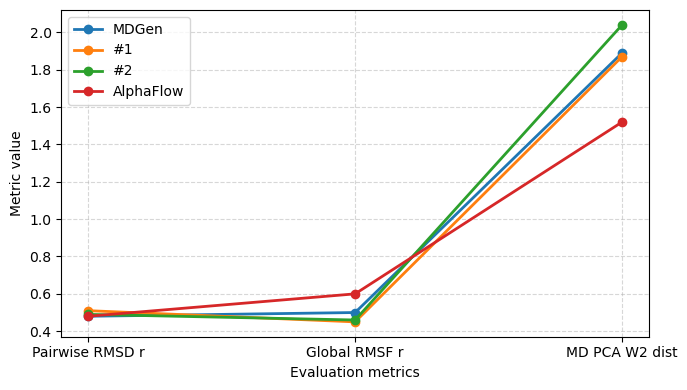

In [ ]:
import matplotlib.pyplot as plt

# -------------------------
# Metrics (x-axis)
# -------------------------
metrics = [
    "Pairwise RMSD r",
    "Global RMSF r",
    "MD PCA W2 dist",
    "Weak contacts J"
]

# -------------------------
# Data (from your tables)
# -------------------------
data = {
    "MDGen":       [0.48, 0.50, 1.89, 0.51],
    "#1":          [0.51, 0.45, 1.87, 0.33],
    "#2":          [0.49, 0.46, 2.04, 0.33],
    "AlphaFlow":   [0.48, 0.60, 1.52, 0.62],
}

# -------------------------
# Plot
# -------------------------
plt.figure(figsize=(8, 4))

for label, values in data.items():
    plt.plot(metrics, values, marker="o", linewidth=2, label=label)

plt.ylabel("Metric value")
plt.xlabel("Evaluation metrics")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
